In [1]:
%matplotlib inline
import sys
import os
DATA_PATH = os.getenv('DATA_PATH')
CODE_PATH = os.getenv('CODE_PATH')
FIGURE_PATH = os.getenv('FIGURE_PATH')

sys.path.insert(0, os.path.join(CODE_PATH))

import pandas as pd
import numpy as np
import json
import re

import time

from src.load import EGRID, BA_DATA

import matplotlib.pyplot as plt

from calendar import month_abbr

import logging.config
logging.config.fileConfig(os.path.join(CODE_PATH, "src/logging.conf"))
logger = logging.getLogger(__name__)

In [2]:
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [6.99, 2.5]
plt.rcParams['grid.color'] = 'k'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.dpi"] = 200
plt.rcParams['font.size'] = 10

import cmocean
cmap = cmocean.cm.cmap_d['phase']

In [3]:
def monthlySums(elec, co2, selected = ["CISO", "MISO", "PJM", "ERCO", "ISNE", "AZPS", "BPAT"],
                savePlots=False, figFolder=""):
    
    df_plot = []
    for i, data in enumerate([elec, co2]):  
        df_plot.append(data.df.loc[:, data.get_cols(selected, field="D")
                                  + data.get_cols(selected, field="NG")].copy(deep=True))

    dates = pd.to_datetime(["2016-%d-1"% idx for idx in df_plot[0].index.tolist()])
    
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(3.42, 6))
    for i, (ax, data, scale, ylab, title) in enumerate(zip(
        (ax1,ax2), [elec, co2], [1e-6,1e-6],
            ["TWh", "Mtons"], ["Electricity Consumption", "Consumption-Based Carbon Emissions"])):

        for ba in selected:
            ax.plot(dates, df_plot[i].loc[:, data.get_cols(ba, field="D")] * scale,
                    label='_nolegend_', marker='o', markersize=2,
                   lw=1)
        
        ax.set_ylabel(ylab)
        ax.set_ylim(bottom=0.)
        ax.set_title(title)

    for ba in selected:
        y2 = 1000*(df_plot[1].loc[:, co2.get_cols(ba, field="D")].values
              / df_plot[0].loc[:, elec.get_cols(ba, field="D")].values)
        ax3.plot(dates, y2, label=ba, marker='o', markersize=2, lw=1, zorder=10)
    
    ax3.set_ylabel("kg/MWh")
    ax3.set_ylim(bottom=0.)
    ax3.set_title("Consumption-Based Carbon Intensity")
    
    ax3.axhline(458, color='k', ls='--', lw=.5, zorder=2)
    #ax3.text(pd.to_datetime("2016-1-1"), 458, 'US')
    ax3.set_yticks([0, 150, 300, 450, 600])
    ax3.set_yticklabels([0, 150, 300, "US\navg", 600])
        
    #ax3.plot([], [], c='k', label='Consumption', marker='o', markersize=2, lw=1)
    #ax3.plot([], [], c='k', label='Production', ls="--", marker='o', markersize=2, lw=1)
    ax3.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.45,-0.8))
    f.autofmt_xdate();
    plt.subplots_adjust(hspace=0.25)
    
    if savePlots:
        f.savefig(os.path.join(FIGURE_PATH, 'main/monthly_sums.pdf'), bbox_inches='tight')
#         f.savefig(os.path.join(FIGURE_PATH, 'main/monthly_sums.png'), bbox_inches='tight')

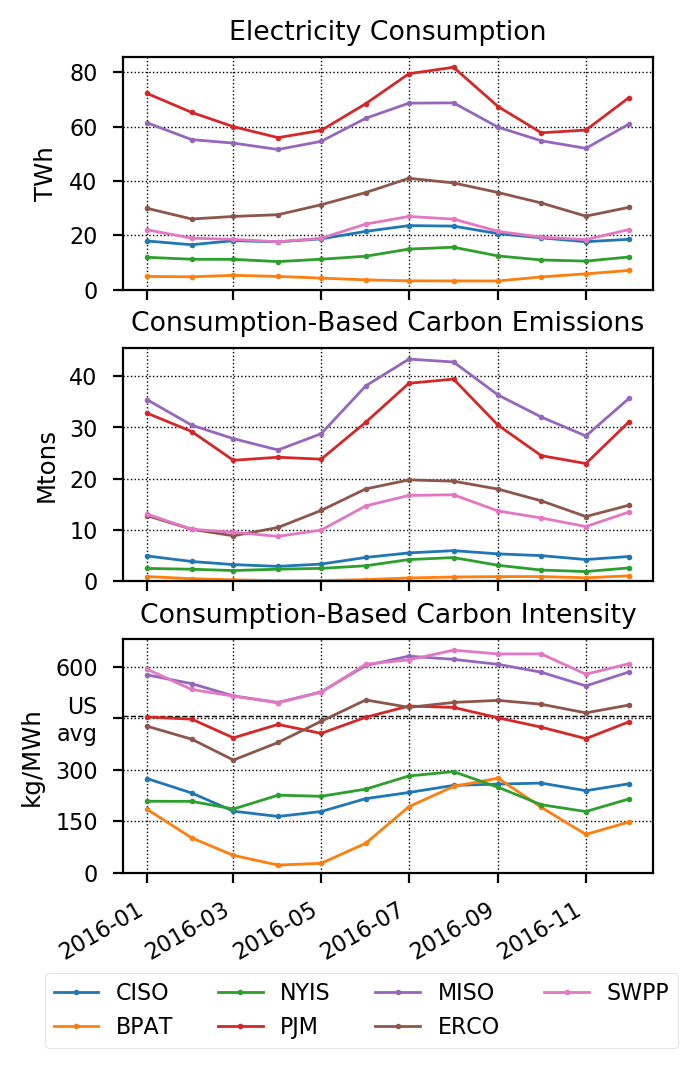

In [4]:
co2 = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_CO2_M.csv"), variable="CO2")
elec = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_E_M.csv"), variable="E")

selected = ["CISO", "BPAT", "NYIS", "PJM", "MISO", "ERCO", "SWPP"]
monthlySums(elec, co2,selected=selected, savePlots=True)

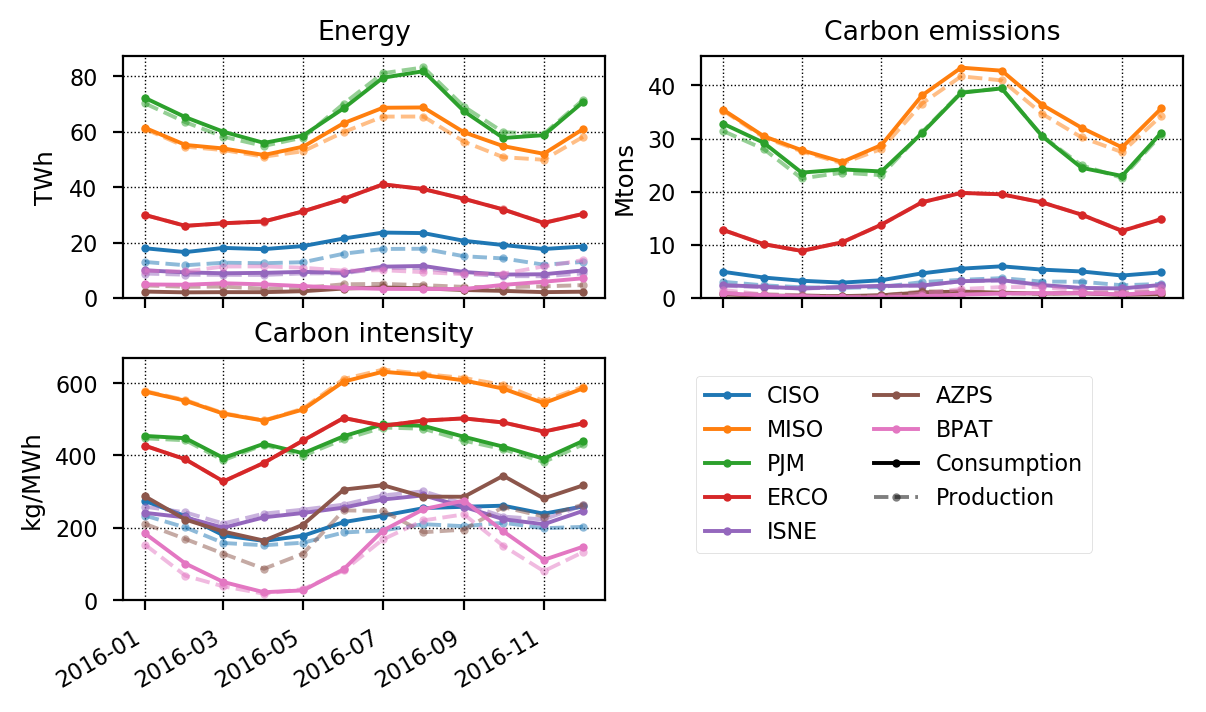

In [5]:
def monthlySumsformat2(elec, co2, selected = ["CISO", "MISO", "PJM", "ERCO", "ISNE", "AZPS", "BPAT"],
                savePlots=False, figFolder=""):
    
    df_plot = []
    for i, data in enumerate([elec, co2]):  
        df_plot.append(data.df.loc[:, data.get_cols(selected, field="D")
                                  + data.get_cols(selected, field="NG")].copy(deep=True))
    
    dates = pd.to_datetime(["2016-%d-1"% idx for idx in df_plot[0].index.tolist()])
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(3.42*2, 4))
    for i, (ax, data, scale, ylab, title) in enumerate(zip(
        (ax1,ax2), [elec, co2], [1e-6,1e-6],
            ["TWh", "Mtons"], ["Energy", "Carbon emissions"])):

        for ba in selected:
            line, = ax.plot(dates, df_plot[i].loc[:, data.get_cols(ba, field="NG")] * scale,
                            label='_nolegend_', alpha=0.5, ls="--", marker='o', markersize=3)
            ax.plot(dates, df_plot[i].loc[:, data.get_cols(ba, field="D")] * scale,
                    label='_nolegend_', color = line.get_color(), marker='o', markersize=3)
        
        ax.set_ylabel(ylab)
        ax.set_ylim(bottom=0.)
        ax.set_title(title)

    for ba in selected:
        y1 = 1000*(df_plot[1].loc[:, co2.get_cols(ba, field="NG")].values
              / df_plot[0].loc[:, elec.get_cols(ba, field="NG")].values)
        y2 = 1000*(df_plot[1].loc[:, co2.get_cols(ba, field="D")].values
              / df_plot[0].loc[:, elec.get_cols(ba, field="D")].values)
        line, = ax3.plot(dates, y1,
                        label='_nolegend_', alpha=0.5, ls="--", marker='o', markersize=3)
        ax3.plot(dates, y2,
                label=ba, color = line.get_color(), marker='o', markersize=3)
    
    ax3.set_ylabel("kg/MWh")
    ax3.set_ylim(bottom=0.)
    ax3.set_title("Carbon intensity")
        
    ax3.plot([], [], c='k', label='Consumption', marker='o', markersize=3)
    ax3.plot([], [], c='k', alpha=0.5, label='Production', ls="--", marker='o', markersize=3)
    ax3.legend(ncol=2, loc='lower center', bbox_to_anchor=(1.6,0.15))
    ax4.axis('off')
    
    f.autofmt_xdate();
    plt.subplots_adjust(hspace=0.25)
    
    if savePlots:
        f.savefig(os.path.join(FIGURE_PATH, 'si/monthly_sums.pdf'), bbox_inches='tight')
#         f.savefig(os.path.join(FIGURE_PATH, 'main/monthly_sums2.png'), bbox_inches='tight')
        #plt.close(f)

selected = ["CISO", "MISO", "PJM", "ERCO", "ISNE", "AZPS", "BPAT"]
monthlySumsformat2(elec, co2,selected=selected, savePlots=True)